In [40]:
import h5py as hdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nexusformat.nexus as nx
from scipy.interpolate import griddata
plt.style.use({'figure.facecolor':'white'})
plt.style.use('M:\\Betrieb_ISF\\Gruppe_A_Orga\\Arbeitsgebiete\\Python_Auswerteskripte\\example_file.mplstyle')
def gather_files_regex(dir: str, regex) -> list:
    '''
    Gathers all files below a directory that match the provided regular expression
    Traverses into sub-directories

    dir -- the directory

    regex -- A regular expression to match filenames
    '''
    #
    import re
    import os
    subdir = dir
    p = re.compile(regex)
    data = []
    for dir, _, files in os.walk(subdir):
        for name in files:
            if p.match(name):
                b = (str(os.path.join(dir, name)))
                data.append(b)

    return data

Missing colon in file 'M:\\Betrieb_ISF\\Gruppe_A_Orga\\Arbeitsgebiete\\Python_Auswerteskripte\\example_file.mplstyle', line 16 ('ttt')


In [3]:
path='C:\\Users\\maede\\DESY\\data\\laht\\d5kW_oZW_LAHT-044.nxs'
f= nx.nxload(path)
print (f.tree)
files=gather_files_regex('C:\\Users\\maede\\DESY\\data\\laht',r'\S*nxs\Z')

root:NXroot
  entry:NXgroup
    instrument:NXgroup
      xspress3:NXgroup
        channel00:NXgroup
          histogram = int32(500x4096)
          scaler:NXgroup
            allevent = float32(500)
            allgood = float32(500)
            inwindow0 = float32(500)
            inwindow1 = float32(500)
            pileup = float32(500)
            resetcounts = float32(500)
            resetticks = float32(500)
            time = float32(500)
            totalticks = float32(500)
        channel01:NXgroup
          histogram = int32(500x4096)
          scaler:NXgroup
            allevent = float32(500)
            allgood = float32(500)
            inwindow0 = float32(500)
            inwindow1 = float32(500)
            pileup = float32(500)
            resetcounts = float32(500)
            resetticks = float32(500)
            time = float32(500)
            totalticks = float32(500)


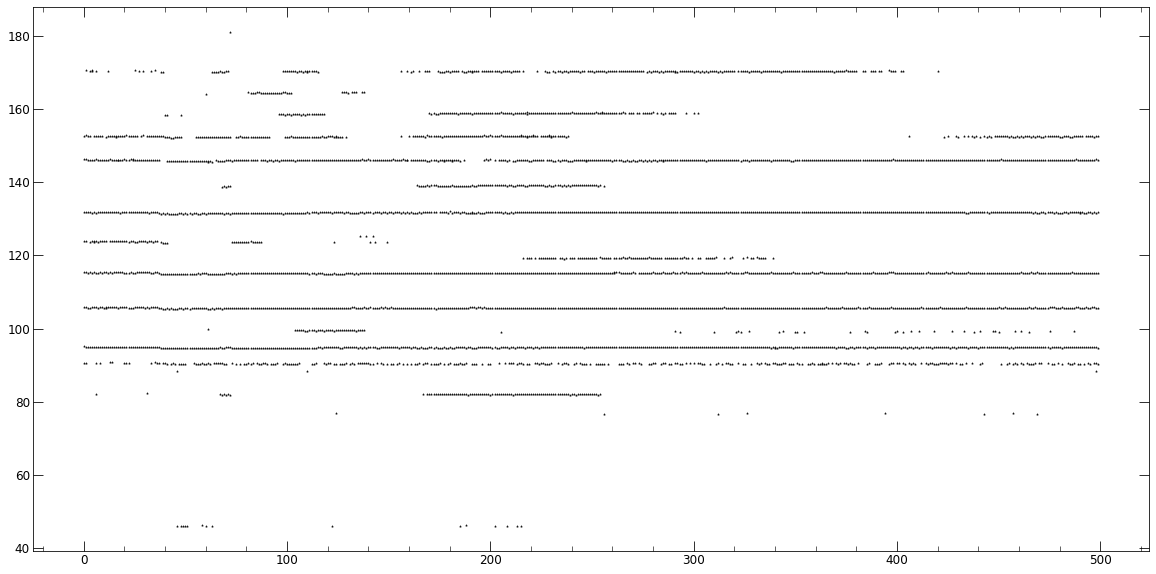

In [4]:
def minmax(x):
    return np.min(x)-1,np.max(x)+1

def extract_between(lst,start,end):
    #print(lst)
    for i in lst:

        if i < end and i >= start :

            return i
    return np.nan

def load_nxs(path):
    import nexusformat.nexus as nx
    f= nx.nxload(path)
    nbframes=np.array(f['entry']['instrument']['xspress3']['channel00']['histogram'][:]).shape[0]
    eresolution=np.array(f['entry']['instrument']['xspress3']['channel00']['histogram'][:]).shape[1]
    energies=np.linspace(25,204.775,eresolution)

    df0=pd.DataFrame(f['entry']['instrument']['xspress3']['channel00']['histogram'][:],columns=energies)
    df1=pd.DataFrame(f['entry']['instrument']['xspress3']['channel01']['histogram'][:],columns=energies)


    df0c=df0.iloc[:,150:4094]
    df1c=df1.iloc[:,150:4094]

    return (df0c, df1c)

def get_energy_peaks (df):
    from scipy.signal import find_peaks as fp
    dfr=pd.DataFrame(index=df.index)
    collector=[]
    for i in df.index:
        x=df.loc[i,:]
        peaks, properties = fp(x, prominence=(20, None),distance=5,width=2)
        collector.append(list(x.index[peaks]))

    dfr['peak_energies[keV]']=collector
    return dfr

def extract_between(lst,start,end):
    #print(lst)
    for i in lst:

        if i < end and i >= start :

            return i
    return np.nan

def separate_energy_peak(df,start,end):
    runner=[]
    for i in df.index:
        runner.append(extract_between(df.loc[i,'peak_energies[keV]'],start,end))
    colname='_'+str(start)+'-'+str(end)+'[keV]'
    df[colname]=runner
    return(df)

def disp_peak_move(df):
    fig,ax=plt.subplots(figsize=(20,10))
    #display(df)
    for i in df.index:
        for e in df.loc[i,'peak_energies[keV]']:
            ax.scatter(i,e,color='k',s=1)

    plt.show()

def sgolay2d(z, window_size, order, derivative=None):
    """
    performs smoothing based on the given parameters, does not accept NaNs as a input
    """
    import numpy as np
    import scipy
    #
    # number of terms in the polynomial expression
    n_terms = (order + 1) * (order + 2) / 2.0

    if window_size % 2 == 0:
        window_size = window_size + 1
        # raise ValueError('window_size must be odd')

    if window_size ** 2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial.
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ...
    # this line gives a list of two item tuple. Each tuple contains
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [(k - n, n) for k in range(order + 1) for n in range(k + 1)]

    # coordinates of points
    ind = np.arange(-half_size, half_size + 1, dtype=np.float64)
    dx = np.repeat(ind, window_size)
    dy = np.tile(ind, [window_size, 1]).reshape(window_size ** 2, )

    # build matrix of system of equation
    A = np.empty((window_size ** 2, len(exps)))
    for i, exp in enumerate(exps):
        A[:, i] = (dx ** exp[0]) * (dy ** exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2 * half_size, z.shape[1] + 2 * half_size
    Z = np.zeros(new_shape)
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] = band - np.abs(np.flipud(z[1:half_size + 1, :]) - band)
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band + np.abs(np.flipud(z[-half_size - 1:-1, :]) - band)
    # left band
    band = np.tile(z[:, 0].reshape(-1, 1), [1, half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs(np.fliplr(z[:, 1:half_size + 1]) - band)
    # right band
    band = np.tile(z[:, -1].reshape(-1, 1), [1, half_size])
    Z[half_size:-half_size, -half_size:] = band + np.abs(np.fliplr(z[:, -half_size - 1:-1]) - band)
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0, 0]
    Z[:half_size, :half_size] = band - np.abs(np.flipud(np.fliplr(z[1:half_size + 1, 1:half_size + 1])) - band)
    # bottom right corner
    band = z[-1, -1]
    Z[-half_size:, -half_size:] = band + np.abs(np.flipud(np.fliplr(z[-half_size - 1:-1, -half_size - 1:-1])) - band)

    # top right corner
    band = Z[half_size, -half_size:]
    Z[:half_size, -half_size:] = band - np.abs(np.flipud(Z[half_size + 1:2 * half_size + 1, -half_size:]) - band)
    # bottom left corner
    band = Z[-half_size:, half_size].reshape(-1, 1)
    Z[-half_size:, :half_size] = band - np.abs(np.fliplr(Z[-half_size:, half_size + 1:2 * half_size + 1]) - band)

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

df0,df1=load_nxs(files[2])
dfr0=get_energy_peaks(df0)
dfr0=separate_energy_peak(dfr0,110,120)
disp_peak_move(dfr0)

In [5]:
def extract_ss_mean(df):
    return (np.mean(df.iloc[:,1][15:30]))

In [6]:
exs=pd.read_excel('experiments.xlsx',sheet_name='Tabelle3',header=0)
exs['data']=exs.Messdatei.apply(load_nxs)

In [7]:
exs['ch0']=exs['data'].apply(lambda x :x[0] )
exs['ch1']=exs['data'].apply(lambda x :x[1] )

exs['ch0_energypeaks']=exs['ch0'].apply(get_energy_peaks)
exs['ch1_energypeaks']=exs['ch1'].apply(get_energy_peaks)

exs['ch0_energypeaks']=exs['ch0_energypeaks'].apply(lambda x : separate_energy_peak(x,103,110))
exs['ch1_energypeaks']=exs['ch1_energypeaks'].apply(lambda x : separate_energy_peak(x,103,110))

exs['ch0_ss']= exs['ch0_energypeaks'].apply(extract_ss_mean)
exs['ch1_ss']= exs['ch1_energypeaks'].apply(extract_ss_mean)



In [8]:
groups={'HA':1,
        'HA3Si1':2,
        'LAHT':3,
        'HAG199':4,
        'LAHTG199':5,
        'LAG199':6,
        'LA3Si1':7,
        'HAref':11,
        'HAucref':12,
        'LAHTref':31,
        'LAHTucref':32,
        'LAref':61,
        }
groups

{'HA': 1,
 'HA3Si1': 2,
 'LAHT': 3,
 'HAG199': 4,
 'LAHTG199': 5,
 'LAG199': 6,
 'LA3Si1': 7,
 'HAref': 11,
 'HAucref': 12,
 'LAHTref': 31,
 'LAHTucref': 32,
 'LAref': 61}

[]


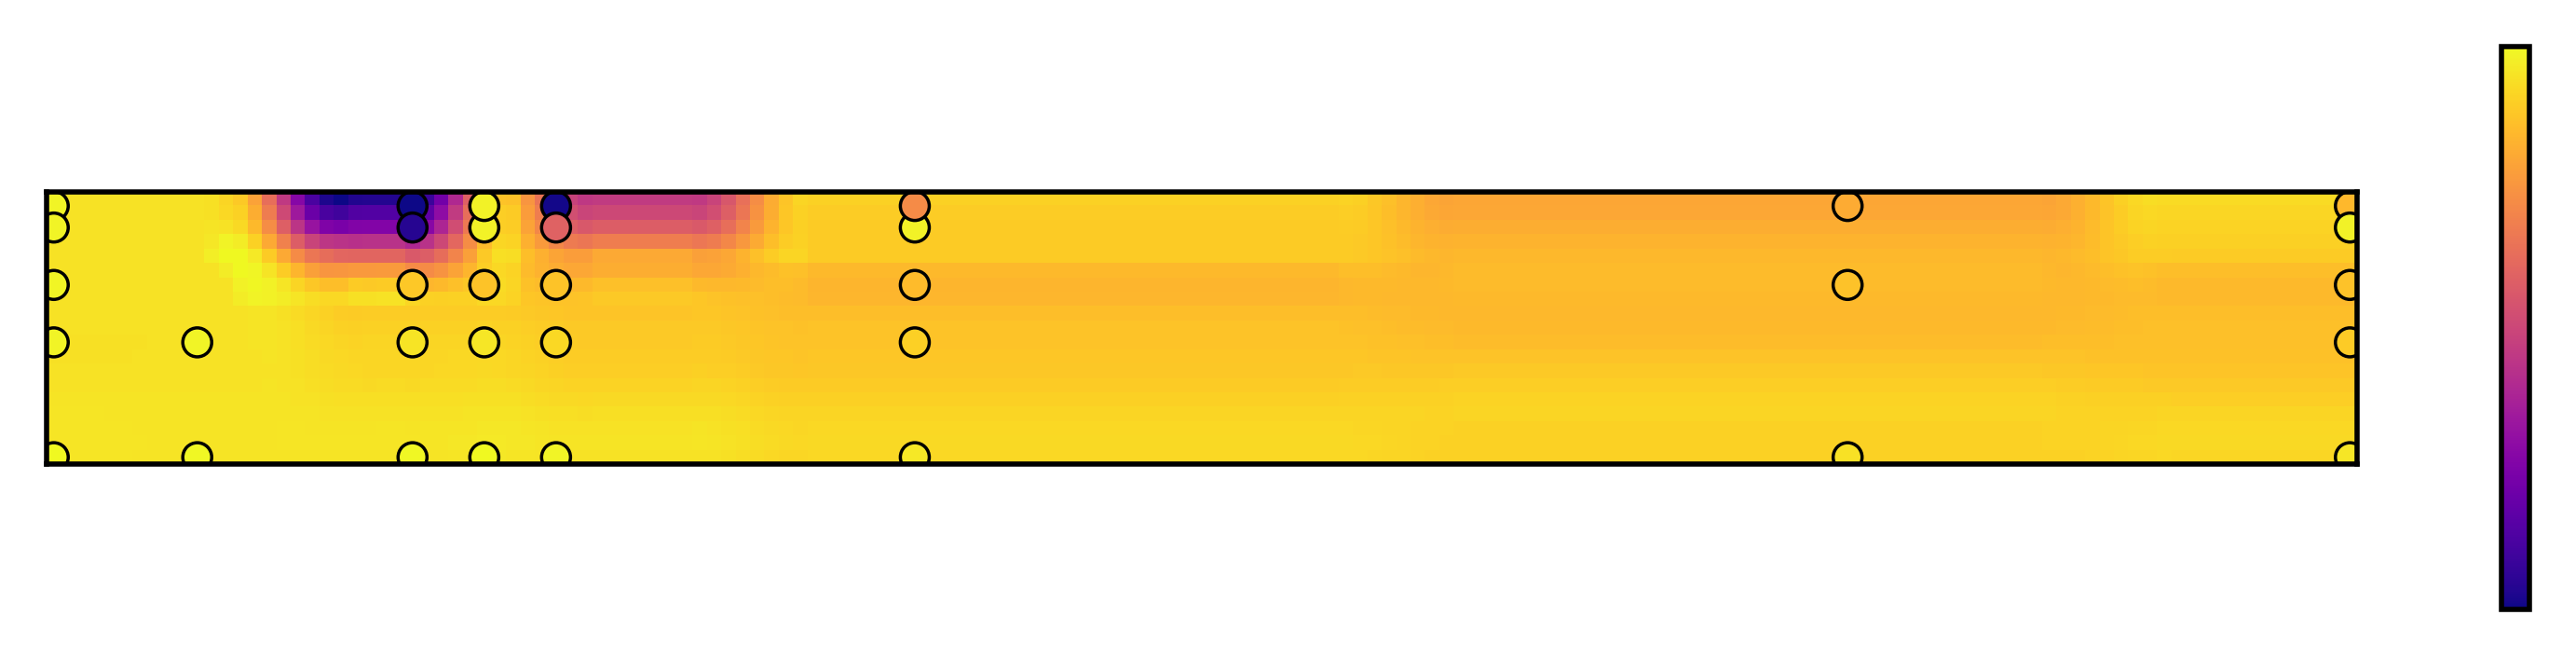

In [47]:
cm=2.5
dfs=exs[exs.Gruppe==groups['LAHT']]
x=-dfs.X
y=-dfs.Z
z=dfs['ch1_ss']
z=z.fillna(exs[exs.Gruppe==groups['LAHTref']]['ch0_ss'].mean())
#z=z.fillna(105.90972527472528)
105.90972527472528
xedges = np.arange(*minmax(x))
yedges = np.arange(*minmax(y))

xcenters = xedges[:-1] + np.diff(xedges[:2])[0] / 2.
ycenters = yedges[:-1] + np.diff(yedges[:2])[0] / 2.

XI, YI = np.meshgrid(xcenters, ycenters)
grid_z0 = griddata(list(zip(x,y)), z, (XI, YI), method='nearest')

fig,ax=plt.subplots(figsize=(20/cm,4/cm))
a=ax.imshow(sgolay2d(grid_z0,9,3),  origin='lower',cmap='plasma')
#a=ax.imshow(grid_z0,  origin='lower',cmap='plasma')

ax.scatter(x+10, y+20, 20,z,  edgecolor='k',lw=0.5,  cmap='plasma')
ax.set_xticklabels([])
ax.set_yticklabels([])
cbar=fig.colorbar(a)
cbar.ax.tick_params(size=0)
cbar.set_ticks([])
#cbar.set_ticks([a.colorbar.vmin + t*(a.colorbar.vmax-a.colorbar.vmin) for t in cbar.ax.get_yticks()])
print(cbar.ax.get_yticks())
#plt.axis('equal')
plt.show()
fig.savefig('result')

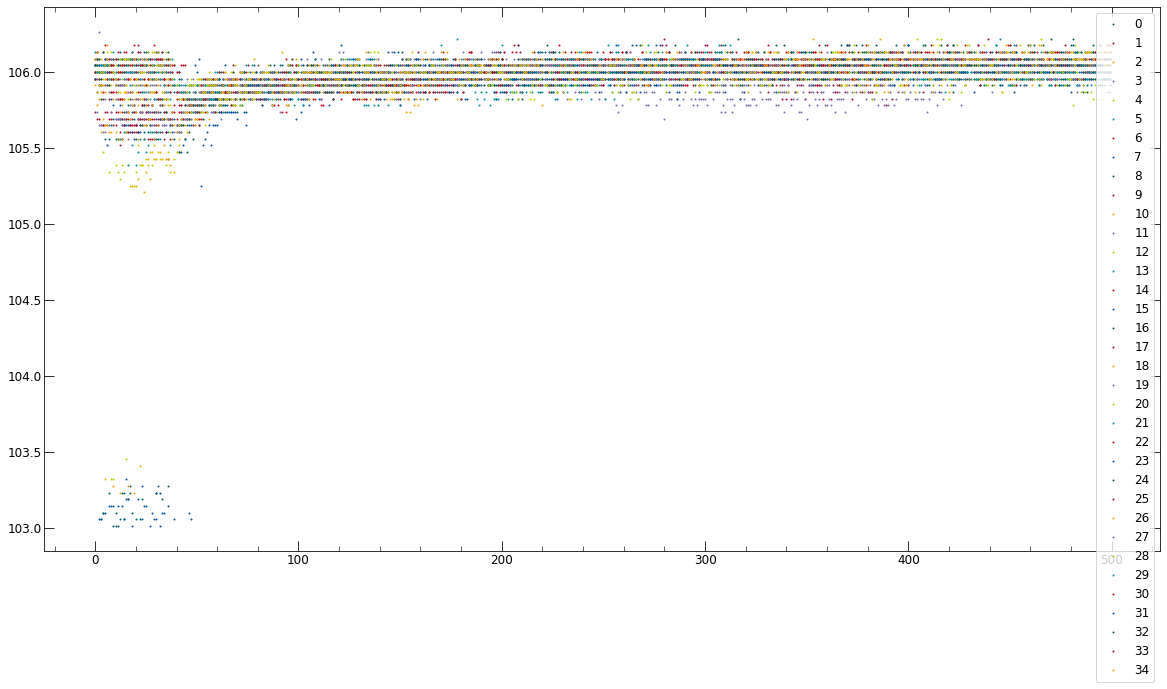

In [10]:
fig,ax=plt.subplots(figsize=(20,10))
for i,val in enumerate(dfs['ch1_energypeaks']):
    ax.plot(val.iloc[:,1],'o',markersize=1,label=i)
plt.legend()
plt.show()

In [11]:
display(dfs)

,Versuchs- Bezeichnung,Gruppe,Schlagzahl-nummer,Zusatzdraht,Grundwerkstoff,"Abstand Schweißen zu Synchrotron (x,y,z) [mm]",X,Y,Z,Thermoelemente,Datum,Messdatei,Kommentare,data,ch0,ch1,ch0_energypeaks,ch1_energypeaks,ch0_ss,ch1_ss
35,LAHT_040,3,259,nein,S235-HT,(-150;0;12),-150,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.734121,105.751681
36,LAHT_041,3,260,nein,S235-HT,(-50;0;12),-50,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.751681,105.780949
37,LAHT_042,3,258,nein,S235-HT,(-25;0;12),-25,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.786802,105.839484
38,LAHT_043,3,257,nein,S235-HT,(-15;0;12),-15,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,T1 abgegangen,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.821923,105.921432
39,LAHT_044,3,251,nein,S235-HT,(0;0;12),0,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.880458,106.029722
40,LAHT_045,3,253,nein,S235-HT,(10;0;12),10,0,12.0,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.868751,106.023868
41,LAHT_046,3,254,nein,S235-HT,"(10;0;2,5)",10,0,2.5,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.938993,106.023868
42,LAHT_047,3,252,nein,S235-HT,"(-15;0;2,5)",-15,0,2.5,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,104.882440,103.111030
43,LAHT_048,3,255,nein,S235-HT,"(-25;0;2,5)",-25,0,2.5,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,NaN,103.137684
44,LAHT_049,3,256,nein,S235-HT,"(-150;0;2,5)",-150,0,2.5,"(4,8)",44543,G:\2021-12-07_Desy_Messdaten\complete\raw\LAHT...,NaN,"([31.585164835164836, 31.629065934065935, 31.6...",31.585165 31.629066 31.672967 31.71...,31.585165 31.629066 31.672967 31.71...,peak_energ...,peak_energ...,105.221941,105.611198
